In [1]:

#=============================================================================
# Modules
#=============================================================================

# Standard modules
import yaml
import os
import numpy as np
import torch
from torch.nn import Sequential
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torchvision
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Custom modules
from logger import logger
from data_preprocessing import combine_label_files
import dataset
from resnet50 import Residual_block
import simclr

#=============================================================================
# Variables
#=============================================================================

dataset_directory = "../data/processed/1.5mmRegions/mph/"
label_directory = "../data/processed/1.5mmRegions/labels/"
model_name = "testing_model"
output_directory = "../outputs/"

# Path to the JSON metadata file
configuration_file_path = "../config/model.yaml"

# Set seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

#=============================================================================
# Functions
#=============================================================================

def get_label_dict(labels: list):
    """generates a dictionary of a list of labels where the keys are class numberings

    Args:
        labels (list): list of labels

    Returns:
        dict: dictionary of labels with class numberings
    """
    label_dict = {}
    for i, label in enumerate(labels):
       label_dict[i] = label
    return label_dict

def evaluate(model:torch.nn.Sequential, testloader:torch.utils.data.DataLoader, device: object):
    """returns the lists of actual labels, predictions, probabilities

    Args:
        model (object): PyTorch model to do predictions on data 
        testloader (object): Dataloader object with test data
        device (object): Device to put pytorch objects on

    Returns:
        list, list, list: lists of actual labels, predictions, probabilities
    """    
    # Set model to evaluation mode
    model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get probabilities
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            
            # Get predicted class
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            
            # Store true labels
            all_labels.extend(labels.cpu().numpy())
            
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    return all_labels, all_preds, all_probs

def get_ROC(all_labels:list, all_preds:list, all_probs:list, file:str):
    """Generates and saves ROC (Receiver Operating Characteristic) curves for a multi-class classification problem.

    Args:
        all_labels (list): True class labels for all samples.
        all_preds (list): Predicted class labels for all samples.
        all_probs (list): Predicted probabilities for each class (should be a 2D array with shape [n_samples, n_classes]).
        file (str): The filename (without extension) where the ROC curve plot will be saved.

    Returns:
        None: The function saves the plot to a file and does not return any value.

    """    
    # Binarize the labels for ROC and AUC calculation
    n_classes = all_probs.shape[1]
    all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    linestyles = ['-', '-.', ':']  # Define different linestyles

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure()

    for i in range(n_classes):
        linestyle = linestyles[i % len(linestyles)]  # Cycle through linestyles if n_classes > len(linestyles)
        plt.plot(fpr[i], tpr[i], linestyle=linestyle, color="black", lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.5f})')

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', linewidth=2, label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.5f})')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', rotation=0, ha='right', fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    plt.savefig(f"{file}.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return None

def hook_fn(module:torch.nn.Sequential, input, output, layer_outputs:dict):
    """Hook function to capture the output of a specific layer in a PyTorch model during forward pass.

    Args:
        module: The layer (or module) in the PyTorch model for which the output should be captured.
        input: The input to the layer (this argument is required by the hook but is not used in this function).
        output: The output from the layer, which will be stored.
        layer_outputs (dict): A dictionary to store the output of the layer. The key is the layer (module), and the value is its output.

    Returns:
        None: The function modifies the layer_outputs dictionary in place and does not return any value.

    """    
    layer_outputs[module] = output

#==========================================================================
# Configuration imports
#==========================================================================

with open(configuration_file_path, "r") as file:
    configuration_data = yaml.safe_load(file)

# Extract model configurations
logger.info(f"importing model configurations...")
gpu                        = configuration_data["gpu"]
test_ratio                 = configuration_data["test_ratio"]
batch_size                 = configuration_data["batch_size"]
supervised                 = configuration_data["supervised"]
in_channels                = configuration_data["in_channels"]
num_classes                = configuration_data["num_classes"]

# Extract training configurations:
logger.info(f"importing training configurations...")
epochs       = configuration_data["training"]["epochs"]
lr           = configuration_data["training"]["optimiser"]["lr"]
beta         = configuration_data["training"]["optimiser"]["beta"]
weight_decay = configuration_data["training"]["optimiser"]["weight_decay"]
temperature  = configuration_data["training"]["loss"]["temperature"]
mode         = configuration_data["training"]["scheduler"]["mode"]
factor       = configuration_data["training"]["scheduler"]["factor"]
patience     = configuration_data["training"]["scheduler"]["patience"]
threshold    = configuration_data["training"]["scheduler"]["threshold"]
min_lr       = configuration_data["training"]["scheduler"]["min_lr"]


#==========================================================================
# Output directories
#==========================================================================

models_directory_path      = f"{output_directory}models/"
training_directory_path    = f"{output_directory}training/"
summaries_directory_path   = f"{output_directory}evaluations/"

#==========================================================================
# Checking output directory exists
#==========================================================================

logger.info(f"Checking output model directory...")
if not os.path.exists(models_directory_path):
        os.makedirs(models_directory_path)
        
logger.info(f"Checking output training directory...")
if not os.path.exists(training_directory_path):
        os.makedirs(training_directory_path)
        
logger.info(f"Checking output evalutions directory...")
if not os.path.exists(summaries_directory_path):
        os.makedirs(summaries_directory_path)
        
#==========================================================================
# Set device
#==========================================================================

if gpu is True:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

2024-08-26 22:44:54,208 - mph_pipeline_logger - INFO - importing model configurations...
2024-08-26 22:44:54,210 - mph_pipeline_logger - INFO - importing training configurations...
2024-08-26 22:44:54,211 - mph_pipeline_logger - INFO - Checking output model directory...
2024-08-26 22:44:54,213 - mph_pipeline_logger - INFO - Checking output training directory...
2024-08-26 22:44:54,214 - mph_pipeline_logger - INFO - Checking output evalutions directory...


In [2]:
#======================================================================
#  Data set generation
#======================================================================

# Image size for images to be loaded into dataset
if supervised is True:
    image_size = 64
else:
    image_size = 128

# Generate data set objects
logger.info(f"Generating supervised data set...")
labels = combine_label_files(label_directory)
label_dict = get_label_dict(labels)
model_dataset = dataset.Labelled_dataset(dataset_directory, label_dict, transform=dataset.get_transform(image_size=image_size))
    
# Split to test and training data sets
logger.info(f"Splitting data set...")
train_dataset, test_dataset = dataset.split_dataset(model_dataset, test_ratio)

# Normalise data set
logger.info(f"Calculating normalisation parameters...")
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
mean, std = dataset.calculate_mean_std(trainloader)

# Dataloading
logger.info(f"Generating dataloader objects...")
transform = dataset.get_transform(mean=mean, std=std, image_size=image_size)
train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2024-08-26 22:46:12,516 - mph_pipeline_logger - INFO - Generating supervised data set...
2024-08-26 22:46:12,530 - mph_pipeline_logger - INFO - Files to be processed found
2024-08-26 22:46:12,588 - mph_pipeline_logger - INFO - Labels found successfully
2024-08-26 22:46:12,595 - mph_pipeline_logger - INFO - Labels found successfully
2024-08-26 22:46:12,604 - mph_pipeline_logger - INFO - Labels found successfully
2024-08-26 22:46:12,625 - mph_pipeline_logger - INFO - Splitting data set...
2024-08-26 22:46:12,690 - mph_pipeline_logger - INFO - Calculating normalisation parameters...
2024-08-26 22:46:33,193 - mph_pipeline_logger - INFO - Generating dataloader objects...


In [21]:
# Show class label allocations
label_dict

{0: 'FoxP3', 1: 'CD68', 2: 'CD8'}

Training loss 1.63 | Test loss 1.55 | Training accuracy: 0.00% | Test accuracy: 0.00% | learning rate 0.001000000: 100%|██████████| 2/2 [00:58<00:00, 29.09s/it]
Training loss 1.21 | Test loss 1.25 | Training accuracy: 34.17% | Test accuracy: 30.50% | learning rate 0.001000000: 100%|██████████| 2/2 [01:09<00:00, 34.79s/it]
Training loss 2.01 | Test loss 1.92 | Training accuracy: 0.00% | Test accuracy: 0.00% | learning rate 0.001000000: 100%|██████████| 2/2 [00:56<00:00, 28.39s/it]
Training loss 1.04 | Test loss 1.00 | Training accuracy: 49.10% | Test accuracy: 52.52% | learning rate 0.001000000: 100%|██████████| 2/2 [01:06<00:00, 33.19s/it]
Training loss 2.39 | Test loss 2.30 | Training accuracy: 0.00% | Test accuracy: 0.00% | learning rate 0.001000000: 100%|██████████| 2/2 [00:55<00:00, 27.98s/it]
Training loss 1.04 | Test loss 1.04 | Training accuracy: 47.60% | Test accuracy: 45.60% | learning rate 0.001000000: 100%|██████████| 2/2 [01:04<00:00, 32.39s/it]
Training loss 2.69 | Test lo

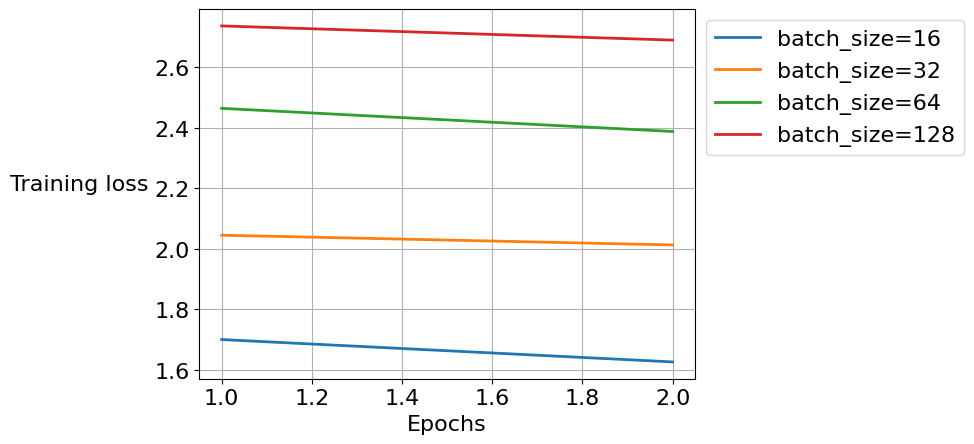

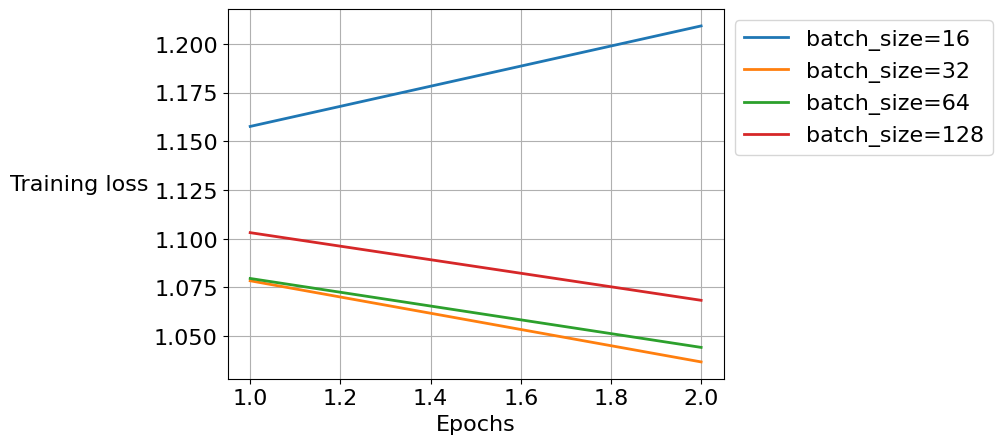

In [5]:
# batch_size experiment
batch_sizes = [16, 32, 64, 128]
losses_cnn = []
losses_class = []
transform = simclr.get_contrastive_transform()
criterion = simclr.InfoNCE(temperature=temperature)

for batch_size in batch_sizes:
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    encoder = simclr.Encoder(block=Residual_block, in_channels=in_channels)
    projection_head = simclr.get_projection_head(encoder_final_dim=encoder.block_in_channels, final_dim=batch_size)
    Simclr = Sequential(encoder, projection_head).to(device)
    optimizer = torch.optim.SGD(Simclr.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_cnn, _ = simclr.train_simclr(model=Simclr, train_data=trainloader, test_data=testloader, criterion=criterion, optimizer=optimizer, device=device, transform=transform, curve_path=f"{training_directory_path}{model_name}_unsupervised_cnn_batch_size_{batch_size}_experiment", epochs=epochs)
    losses_cnn.append(loss_cnn)
    
    Simclr_infer = simclr.get_inference_model(Simclr, in_channels=encoder.block_in_channels * 9, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Simclr_infer[1].parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_class, _ = simclr.train_simclr_infer(model=Simclr_infer, train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_unsupervised_class_batch_size_{batch_size}_experiment", epochs=epochs)
    losses_class.append(loss_class)

plt.figure()
for i, loss in enumerate(losses_cnn):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'batch_size={batch_sizes[i]}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_cnn_batch_size_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.figure()
for i, loss in enumerate(losses_class):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'batch_size={batch_sizes[i]}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_class_batch_size_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
# lr experiment
batch_size = 128
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
losses_cnn = []
losses_class = []

for lr in lrs:
    
    encoder = simclr.Encoder(block=Residual_block, in_channels=in_channels)
    projection_head = simclr.get_projection_head(encoder_final_dim=encoder.block_in_channels, final_dim=batch_size)
    Simclr = Sequential(encoder, projection_head).to(device)
    optimizer = torch.optim.SGD(Simclr.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_cnn, _ = simclr.train_simclr(model=Simclr, train_data=trainloader, test_data=testloader, criterion=criterion, optimizer=optimizer, device=device, transform=transform, curve_path=f"{training_directory_path}{model_name}_unsupervised_cnn_learning_rate_{lr:.5f}_experiment", epochs=epochs)
    losses_cnn.append(loss_cnn)
    
    Simclr_infer = simclr.get_inference_model(Simclr, in_channels=encoder.block_in_channels * 9, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Simclr_infer[1].parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_class, _ = simclr.train_simclr_infer(model=Simclr_infer, train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_unsupervised_class_learning_rate_{lr:.5f}_experiment", epochs=epochs)
    losses_class.append(loss_class)

plt.figure()
for i, loss in enumerate(losses_cnn):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\eta$={lrs[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_cnn_learning_rate_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.figure()
for i, loss in enumerate(losses_class):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\eta$={lrs[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_class_learning_rate_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

Training loss 2.78 | Test loss 2.58 | grad norm 19.32 | learning rate 0.001000000: 100%|██████████| 10/10 [04:51<00:00, 29.16s/it]
Training loss 1.02 | Test loss 1.01 | Training accuracy: 51.92% | Test accuracy: 49.06% | learning rate 0.001000000: 100%|██████████| 10/10 [05:07<00:00, 30.73s/it]
Training loss 2.72 | Test loss 2.65 | grad norm 18.55 | learning rate 0.001000000: 100%|██████████| 10/10 [04:23<00:00, 26.39s/it]
Training loss 1.02 | Test loss 1.01 | Training accuracy: 54.28% | Test accuracy: 49.37% | learning rate 0.001000000: 100%|██████████| 10/10 [05:05<00:00, 30.57s/it]
Training loss 2.74 | Test loss 2.66 | grad norm 18.37 | learning rate 0.001000000: 100%|██████████| 10/10 [04:25<00:00, 26.53s/it]
Training loss 1.01 | Test loss 0.99 | Training accuracy: 52.47% | Test accuracy: 54.40% | learning rate 0.001000000: 100%|██████████| 10/10 [05:02<00:00, 30.25s/it]
Training loss 2.75 | Test loss 2.48 | grad norm 20.16 | learning rate 0.001000000: 100%|██████████| 10/10 [04:15

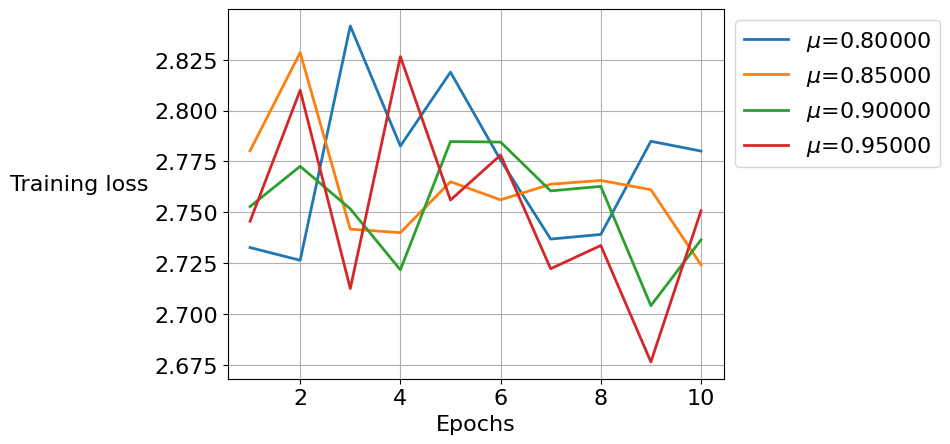

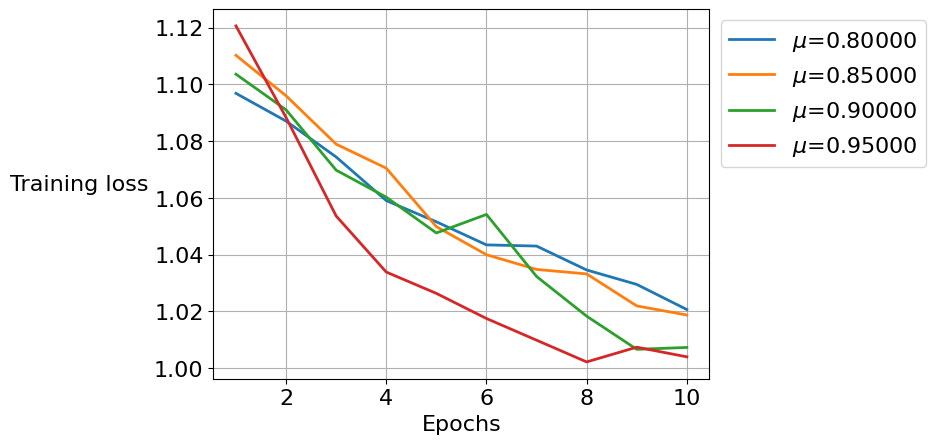

In [4]:
# beta experiment
lr = 0.001
betas = [0.8, 0.85, 0.9, 0.95]
losses_cnn = []
losses_class = []

for beta in betas:
    
    encoder = simclr.Encoder(block=Residual_block, in_channels=in_channels)
    projection_head = simclr.get_projection_head(encoder_final_dim=encoder.block_in_channels, final_dim=batch_size)
    Simclr = Sequential(encoder, projection_head).to(device)
    optimizer = torch.optim.SGD(Simclr.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_cnn, _ = simclr.train_simclr(model=Simclr, train_data=trainloader, test_data=testloader, criterion=criterion, optimizer=optimizer, device=device, transform=transform, curve_path=f"{training_directory_path}{model_name}_unsupervised_cnn_momentum_{beta:.5f}_experiment", epochs=epochs)
    losses_cnn.append(loss_cnn)
    
    Simclr_infer = simclr.get_inference_model(Simclr, in_channels=encoder.block_in_channels * 9, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Simclr_infer[1].parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_class, _ = simclr.train_simclr_infer(model=Simclr_infer, train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_unsupervised_class_momentum_{beta:.5f}_experiment", epochs=epochs)
    losses_class.append(loss_class)

plt.figure()
for i, loss in enumerate(losses_cnn):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\mu$={betas[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_cnn_momentum_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.figure()
for i, loss in enumerate(losses_class):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\mu$={betas[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_class_momentum_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

Training loss 2.69 | Test loss 2.49 | grad norm 15.84 | learning rate 0.001000000: 100%|██████████| 10/10 [04:18<00:00, 25.85s/it]
Training loss 0.98 | Test loss 0.96 | Training accuracy: 57.58% | Test accuracy: 59.12% | learning rate 0.001000000: 100%|██████████| 10/10 [05:02<00:00, 30.28s/it]
Training loss 2.60 | Test loss 2.56 | grad norm 16.79 | learning rate 0.001000000: 100%|██████████| 10/10 [04:16<00:00, 25.66s/it]
Training loss 0.99 | Test loss 0.98 | Training accuracy: 55.46% | Test accuracy: 53.14% | learning rate 0.001000000: 100%|██████████| 10/10 [05:15<00:00, 31.53s/it]
Training loss 2.69 | Test loss 2.61 | grad norm 16.37 | learning rate 0.001000000: 100%|██████████| 10/10 [04:19<00:00, 25.91s/it]
Training loss 0.98 | Test loss 0.97 | Training accuracy: 54.28% | Test accuracy: 55.97% | learning rate 0.001000000: 100%|██████████| 10/10 [05:09<00:00, 30.91s/it]


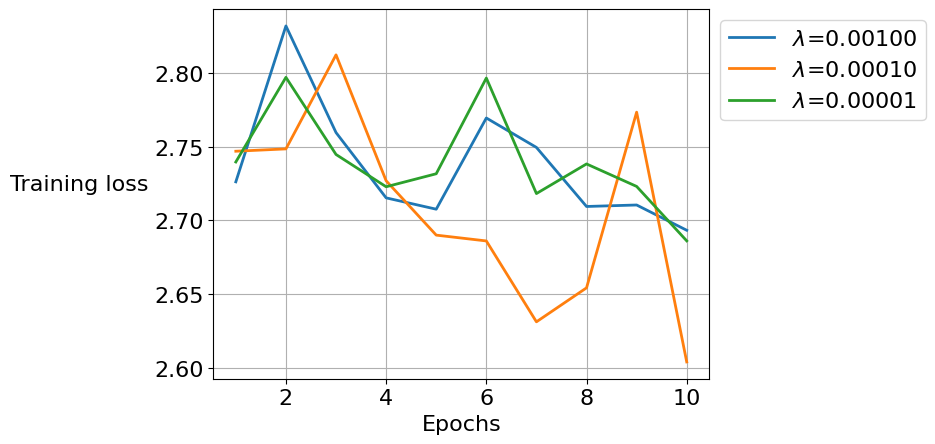

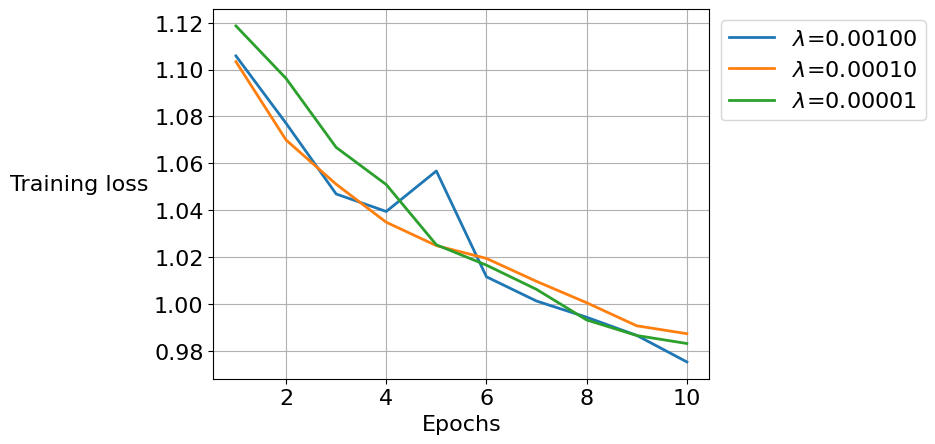

In [5]:
# Weight decay experiment
beta = 0.95
weight_decays = [0.001, 0.0001, 0.00001]
losses_cnn = []
losses_class = []

for weight_decay in weight_decays:
    
    encoder = simclr.Encoder(block=Residual_block, in_channels=in_channels)
    projection_head = simclr.get_projection_head(encoder_final_dim=encoder.block_in_channels, final_dim=batch_size)
    Simclr = Sequential(encoder, projection_head).to(device)
    optimizer = torch.optim.SGD(Simclr.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_cnn, _ = simclr.train_simclr(model=Simclr, train_data=trainloader, test_data=testloader, criterion=criterion, optimizer=optimizer, device=device, transform=transform, curve_path=f"{training_directory_path}{model_name}_unsupervised_cnn_weight_decay_{weight_decay:.5f}_experiment", epochs=epochs)
    losses_cnn.append(loss_cnn)
    
    Simclr_infer = simclr.get_inference_model(Simclr, in_channels=encoder.block_in_channels * 9, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Simclr_infer[1].parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_class, _ = simclr.train_simclr_infer(model=Simclr_infer, train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_unsupervised_class_weight_decay_{weight_decay:.5f}_experiment", epochs=epochs)
    losses_class.append(loss_class)

plt.figure()
for i, loss in enumerate(losses_cnn):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\lambda$={weight_decays[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_cnn_weight_decay_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.figure()
for i, loss in enumerate(losses_class):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\lambda$={weight_decays[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_class_weight_decay_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

Training loss 2.69 | Test loss 2.58 | grad norm 3.49 | learning rate 0.001000000: 100%|██████████| 10/10 [04:20<00:00, 26.01s/it]
Training loss 1.00 | Test loss 0.97 | Training accuracy: 53.57% | Test accuracy: 57.55% | learning rate 0.001000000: 100%|██████████| 10/10 [05:05<00:00, 30.57s/it]
Training loss 2.70 | Test loss 2.53 | grad norm 15.78 | learning rate 0.001000000: 100%|██████████| 10/10 [04:19<00:00, 25.93s/it]
Training loss 0.98 | Test loss 0.97 | Training accuracy: 55.54% | Test accuracy: 56.92% | learning rate 0.001000000: 100%|██████████| 10/10 [05:05<00:00, 30.51s/it]
Training loss 0nan | Test loss 0nan | grad norm nan | learning rate 0.001000000: 100%|██████████| 10/10 [04:14<00:00, 25.50s/it]
Training loss 0nan | Test loss 0nan | Training accuracy: 31.50% | Test accuracy: 34.28% | learning rate 0.001000000: 100%|██████████| 10/10 [05:02<00:00, 30.22s/it]


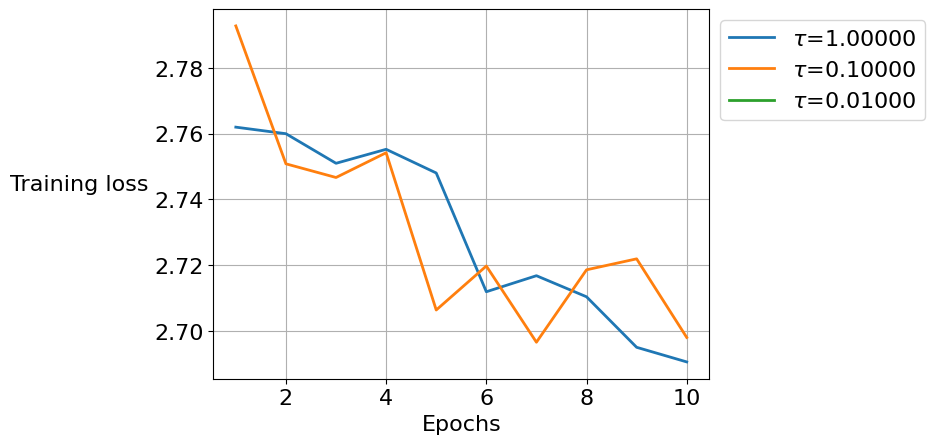

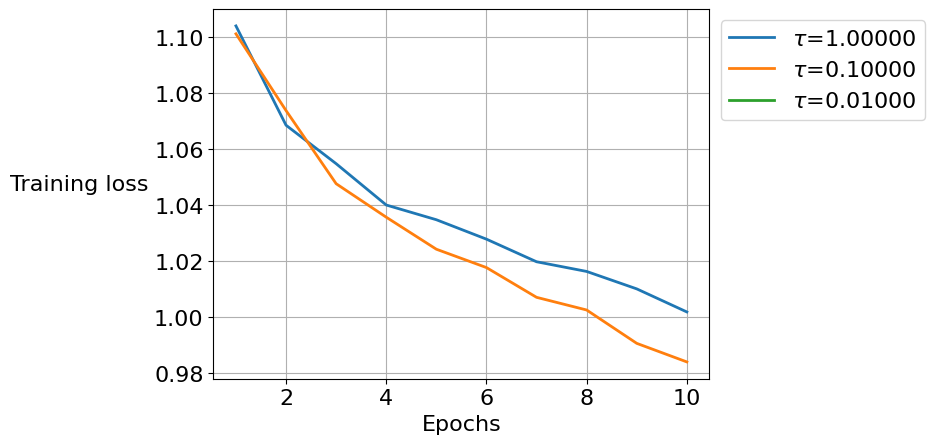

In [6]:
# temperature experiment
weight_decay = 0.001
temperatures = [1, 0.1, 0.01]
losses_cnn = []
losses_class = []

for temperature in temperatures:
    
    criterion = simclr.InfoNCE(temperature=temperature)
    encoder = simclr.Encoder(block=Residual_block, in_channels=in_channels)
    projection_head = simclr.get_projection_head(encoder_final_dim=encoder.block_in_channels, final_dim=batch_size)
    Simclr = Sequential(encoder, projection_head).to(device)
    optimizer = torch.optim.SGD(Simclr.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_cnn, _ = simclr.train_simclr(model=Simclr, train_data=trainloader, test_data=testloader, criterion=criterion, optimizer=optimizer, device=device, transform=transform, curve_path=f"{training_directory_path}{model_name}_unsupervised_cnn_temperature_{temperature:.5f}_experiment", epochs=epochs)
    losses_cnn.append(loss_cnn)
    
    Simclr_infer = simclr.get_inference_model(Simclr, in_channels=encoder.block_in_channels * 9, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Simclr_infer[1].parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss_class, _ = simclr.train_simclr_infer(model=Simclr_infer, train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_unsupervised_class_weight_decay_{weight_decay:.5f}_experiment", epochs=epochs)
    losses_class.append(loss_class)

plt.figure()
for i, loss in enumerate(losses_cnn):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=rf'$\tau$={temperatures[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_cnn_temperature_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.figure()
for i, loss in enumerate(losses_class):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=rf'$\tau$={temperatures[i]:.5f}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/unsupervised_class_temperature_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

Training loss 2.45 | Test loss 2.24 | grad norm 16.48 | learning rate 0.000001000: 100%|██████████| 100/100 [43:03<00:00, 25.84s/it]
Training loss 0.92 | Test loss 0.96 | Training accuracy: 65.75% | Test accuracy: 56.29% | learning rate 0.000001000: 100%|██████████| 100/100 [49:58<00:00, 29.99s/it]


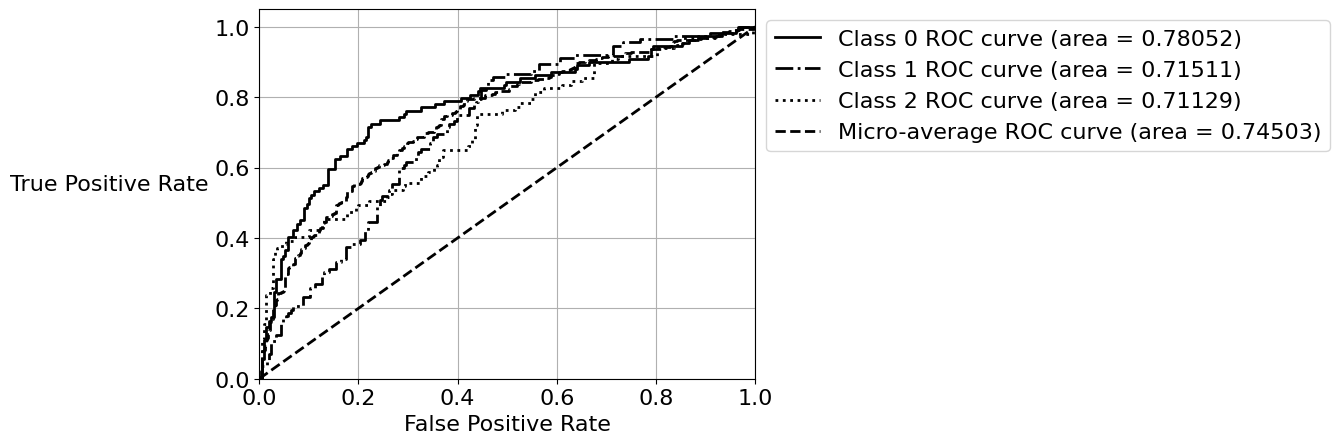

In [10]:
# Running for large number of epochs
temperature = 0.1

encoder = simclr.Encoder(block=Residual_block, in_channels=in_channels)
projection_head = simclr.get_projection_head(encoder_final_dim=encoder.block_in_channels, final_dim=batch_size)
Simclr = Sequential(encoder, projection_head).to(device)
optimizer = torch.optim.SGD(Simclr.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
criterion = simclr.InfoNCE(temperature=temperature)
scheduler = ReduceLROnPlateau(optimizer,  mode=mode, factor=factor, patience=patience, threshold=threshold, min_lr=min_lr)
_, _= simclr.train_simclr(model=Simclr, train_data=trainloader, test_data=testloader, criterion=criterion, optimizer=optimizer, device=device, transform=transform, curve_path=f"{training_directory_path}{model_name}_unsupervised_cnn_epoch_100", scheduler=scheduler, epochs=100)

Simclr_infer = simclr.get_inference_model(Simclr, in_channels=encoder.block_in_channels * 9, num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(Simclr_infer[1].parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer,  mode=mode, factor=factor, patience=patience, threshold=threshold, min_lr=min_lr)
_, _ = simclr.train_simclr_infer(model=Simclr_infer, train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_unsupervised_class_epoch_100", scheduler=scheduler, epochs=100)

simclr.save_model(Simclr_infer, f"{models_directory_path}{model_name}_unsupervised_epoch_100.pth")

all_labels, all_preds, all_probs = evaluate(model=Simclr_infer, testloader=testloader, device=device)
get_ROC(all_labels=all_labels, all_preds=all_preds, all_probs=all_probs, file=f"../report/report-images/{model_name}__unsupervised_epoch_100_ROC")
f1 = f1_score(all_labels, all_preds, average='macro')
accuracy = simclr.accuracy(testloader,model=Simclr_infer, device=device)
conf_matrix = confusion_matrix(all_labels, all_preds)

with open(f"../report/code/{model_name}_unsupervised_evaluation_epoch_100.txt", 'w') as f:
    f.write(f"F1 Score (Macro): {f1:.4f}\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(conf_matrix, separator=', ') + "\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")

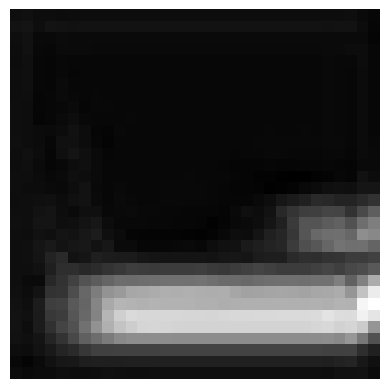

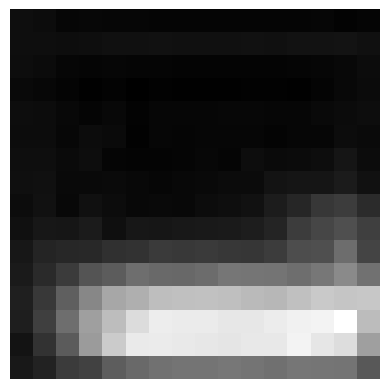

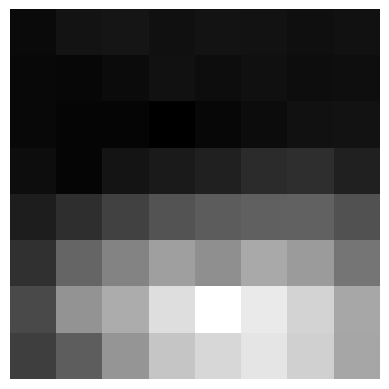

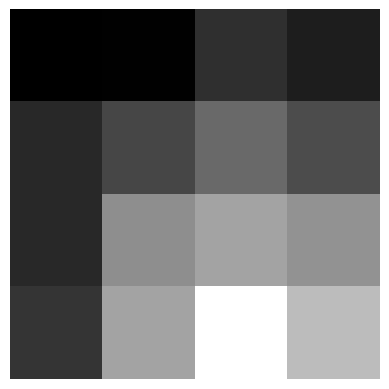

In [19]:
# Get mean layer outputs

# Set model to eval mode
Simclr_infer.eval()

# Dictionary to store the outputs of each layer
outputs = {}

def hook_fn(module:torch.nn.Sequential, input, output:torch.Tensor, layer_name:str):
    """Hook function to capture the output of a specific layer in a PyTorch model during forward pass.

    Args:
        module (torch.nn.Sequential): The layer (or module) in the PyTorch model for which the output should be captured.
        input: The input to the layer (this argument is required by the hook but is not used in this function).
        output (torch.Tensor): The output from the layer, which will be stored.
        layer_name (str): name of layer to store its outputs.

    Returns:
        None: The function modifies the layer_outputs dictionary in place and does not return any value.

    """    
    outputs[layer_name] = output

# Register hooks to capture the outputs after layers 1-4
Simclr_infer[0].layer1.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer1"))
Simclr_infer[0].layer2.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer2"))
Simclr_infer[0].layer3.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer3"))
Simclr_infer[0].layer4.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer4"))

images, labels = next(iter(testloader))
images = images.to(device)

# Run the image through the model
with torch.no_grad():
    Simclr_infer(images)
    
# Visualize the outputs of each layer
for layer_name, output in outputs.items():
    # Select the first image's output
    output = output[0]

    # Average across channels to convert to a 2D image (if necessary)
    if output.dim() == 3:  # If output is [C, H, W]
        output = output.mean(dim=0)

    # Normalize the output to [0, 1] for visualization
    output -= output.min()
    output /= output.max()

    # Plot the output
    plt.figure()
    plt.imshow(output.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.savefig(f"../report/report-images/{model_name}_{layer_name}_unsupervised_output.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

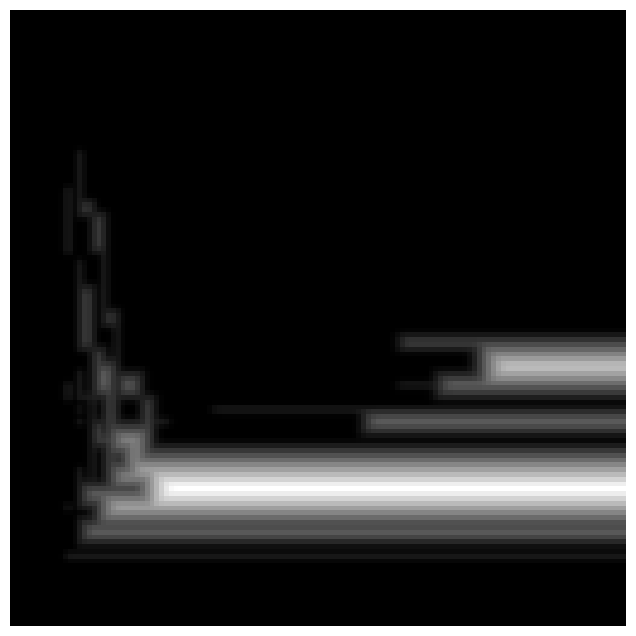

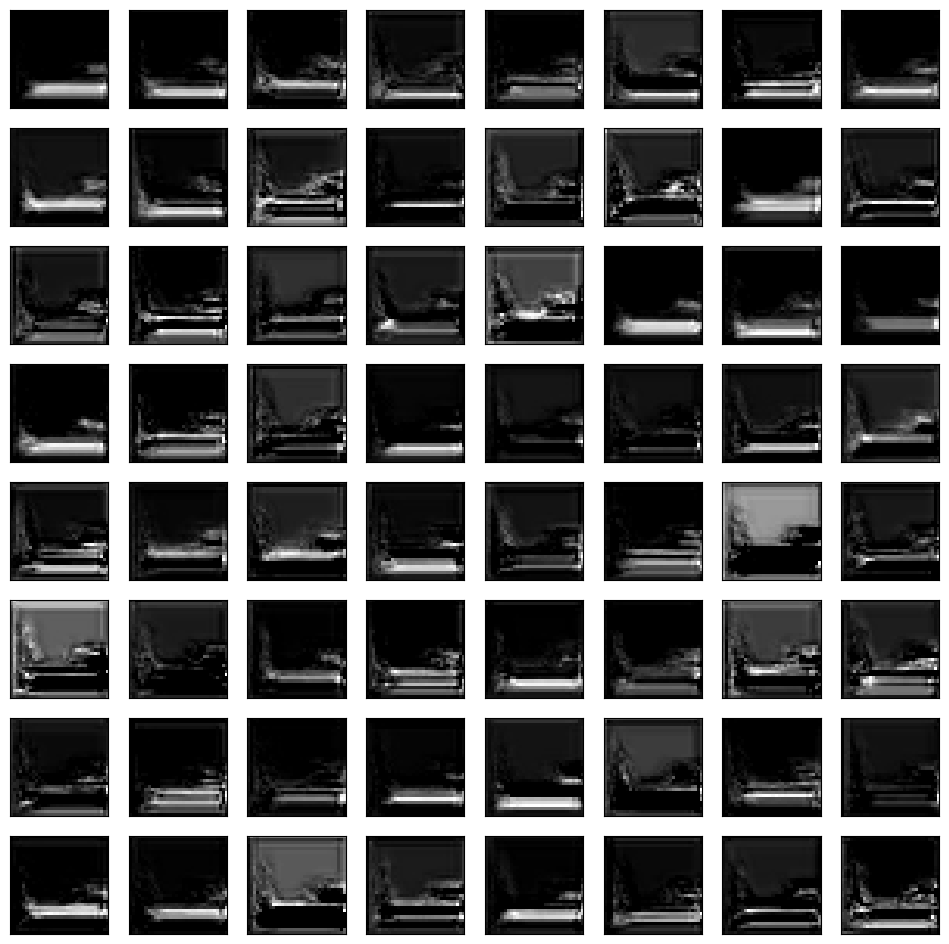

<Figure size 800x800 with 0 Axes>

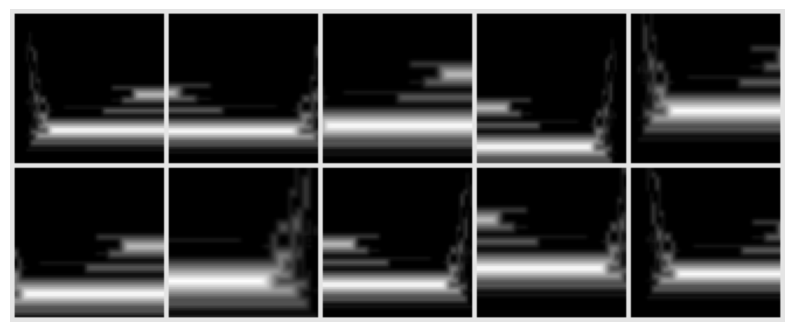

In [27]:
# Get layer 1 feature maps

# Visualize the outputs of each layer
for layer_name, output in outputs.items():
    # Select the first image's output
    output = output[0]
    if layer_name == "layer1":
        break
    
plt.figure(figsize=(8, 8))  # Adjust the size as needed
plt.imshow(images[0].cpu().numpy().squeeze(axis=0), cmap='gray')
plt.axis('off')
image_class = int(labels[0].cpu().numpy())
plt.savefig(f"../report/report-images/unsupervised_example_image_label_{label_dict[image_class]}.pdf", format='pdf', dpi=300, bbox_inches='tight')


# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(12, 12))  # Adjust the size as needed
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(output[ix-1, :, :].cpu().numpy(), cmap='gray')
        ix += 1
# show the figure
plt.savefig(f"../report/report-images/{model_name}_{layer_name}_unsupervised_example_image_label_{label_dict[image_class]}_feature_map.pdf", format='pdf', dpi=300, bbox_inches='tight')

# plot example views of augmentations
plt.figure(figsize=(8, 8))
imgs = torch.stack([transform(images[0]) for i in range(10)], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=5, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(10, 5))
plt.imshow(img_grid.cpu().numpy())
plt.axis("off")
plt.savefig(f"../report/report-images/unsupervised_example_image_label_{label_dict[image_class]}_augmentations.pdf", format='pdf', dpi=300, bbox_inches='tight')